In [1]:
# This enables auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Import the model
from iris.src.chat_model.model import model

INFO:iris.src.chat_model.model_settings:Using environment: local
INFO:iris.src.chat_model.model_settings:Using API base URL: https://api.openai.com/v1


In [6]:
# Define conversation for testing
conversation = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant specialized in accounting."},
        {"role": "user", "content": "summarize the internal capm document"}
    ]
}

# You can modify the conversation above to test different scenarios

In [7]:
# Call the model function with our conversation and debug mode enabled
result_generator = model(conversation, debug_mode=True)

# Collect all response chunks and debug data
response_chunks = []
debug_data = None
process_monitor_output = None

for chunk in result_generator:
    # Check if this is legacy debug data 
    if chunk.startswith("\n\nDEBUG_DATA:"):
        debug_data_json = chunk.replace("\n\nDEBUG_DATA:", "")
        import json
        debug_data = json.loads(debug_data_json)
    # Check if this is process monitor output (more structured output between horizontal rules)
    elif chunk.startswith("\n\n---\n## Process Monitoring Summary"):
        process_monitor_output = chunk
    else:
        response_chunks.append(chunk)
        print(chunk, end="", flush=True)

2025-04-07 14:37:08,374 - root - INFO - Logging system initialized
2025-04-07 14:37:08,374 - root - INFO - Initializing model setup (sync core)...
2025-04-07 14:37:08,375 - iris.src.initial_setup.ssl.ssl - INFO - SSL certificate setup skipped in local environment
2025-04-07 14:37:08,375 - iris.src.initial_setup.oauth.oauth - INFO - Using API key authentication from local settings
2025-04-07 14:37:08,376 - iris.src.initial_setup.oauth.oauth - INFO - Using OpenAI API key from settings: sk-proj...
2025-04-07 14:37:08,376 - root - INFO - Processing input conversation...
2025-04-07 14:37:08,376 - iris.src.conversation_setup.conversation - INFO - Processed conversation: 2 messages filtered to 1 messages
2025-04-07 14:37:08,377 - root - INFO - Conversation processed: 1 messages
2025-04-07 14:37:08,377 - root - INFO - Getting routing decision...
2025-04-07 14:37:08,377 - iris.src.agents.agent_router.router - INFO - Getting routing decision using model: gpt-4o-mini-2024-07-18
2025-04-07 14:37:0

---
# 📋 Research Plan

## Research Statement
The user is requesting a summary of the Corporate Accounting Policy Manuals (CAPM) document. This requires a content analysis of the internal CAPM database to provide an overview of its key policies and procedures. The scope is 'research' as the user is looking for a detailed summary rather than a list of documents. Proceed to analyze the internal_capm database to extract and summarize the main points of the CAPM document.

Searching the following databases: Corporate Accounting Policy Manuals.

---


2025-04-07 14:37:12,918 - root - INFO - Displayed simplified research plan.
2025-04-07 14:37:12,918 - root - INFO - Starting 1 database queries concurrently...
2025-04-07 14:37:12,919 - iris.src.chat_model.model - INFO - Thread executing query 1/1 for database: internal_capm
2025-04-07 14:37:12,919 - root - INFO - Submitted 1 queries to thread pool.
2025-04-07 14:37:12,920 - iris.src.agents.database_subagents.database_router - INFO - Routing query (sync) to database: internal_capm with scope: research
2025-04-07 14:37:12,921 - iris.src.agents.database_subagents.internal_capm.subagent - INFO - Querying Internal CAPM database: 'Summary of key policies and procedures in CAPM' with scope: research
2025-04-07 14:37:12,921 - iris.src.agents.database_subagents.internal_capm.subagent - INFO - Fetching full CAPM catalog (environment: local)
2025-04-07 14:37:12,929 - iris.src.agents.database_subagents.internal_capm.subagent - INFO - Retrieved 1 CAPM catalog entries from database
2025-04-07 14:37



---
**Database:** Corporate Accounting Policy Manuals
**Query:** `Summary of key policies and procedures in CAPM`
**Status:** ℹ️ Found related contextual information, but not a direct answer.
---

2025-04-07 14:37:21,165 - root - INFO - All concurrent database queries completed processing.




## 📊 Research Summary


2025-04-07 14:37:21,166 - root - INFO - Calling generate_streaming_summary (assuming sync generator)
2025-04-07 14:37:21,166 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating final summary for scope: research
2025-04-07 14:37:21,167 - iris.src.chat_model.model_settings - INFO - Using large model: gpt-4o-2024-08-06 in local environment
2025-04-07 14:37:21,167 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating streaming research summary using model: gpt-4o-2024-08-06
2025-04-07 14:37:21,168 - iris.src.agents.agent_summarizer.summarizer - INFO - Summarizing detailed research from 1 databases.
2025-04-07 14:37:21,168 - iris.src.agents.agent_summarizer.summarizer - INFO - Initiating Summarizer stream API call
2025-04-07 14:37:21,182 - iris.src.llm_connectors.rbc_openai - INFO - Using API key: sk-proj...
2025-04-07 14:37:21,182 - iris.src.llm_connectors.rbc_openai - INFO - Using API base URL: https://api.openai.com/v1
2025-04-07 14:37:21,183 - iris.src.llm_conn

## Key Findings

The research focused on understanding the Capital Asset Pricing Model (CAPM) as outlined in the Corporate Accounting Policy Manuals. The primary document reviewed, titled "CAPM_Calculation_Methodology," provides a detailed explanation of the CAPM formula and its components, which are crucial for calculating the expected return on an asset or investment.

### CAPM Formula and Components

The CAPM formula is central to determining the expected return on an investment, accounting for risk and market conditions. The formula is expressed as:

**Expected Return (ERi) = Risk-Free Rate (Rf) + Beta (βi) * (Expected Market Return (ERm) - Risk-Free Rate (Rf))**

- **Risk-Free Rate (Rf):** This is the theoretical return of an investment with zero risk, typically based on long-term government bond yields. The maturity of the bond should match the investment horizon.
- **Beta (βi):** This measures the asset's systematic risk relative to the market. A beta of 1 indicates the asset mo

2025-04-07 14:37:29,696 - iris.src.llm_connectors.rbc_openai - INFO - Stream finished. Logging usage from final chunk.
2025-04-07 14:37:29,696 - iris.src.llm_connectors.rbc_openai - INFO - Token usage - Completion: 478 ($0.0000), Prompt: 3183 ($0.0000), Total: 3661 tokens, Total Cost: $0.0000




---
Completed processing 1 database queries for scope 'research'.


2025-04-07 14:37:29,698 - root - INFO - Completed process for scope 'research'


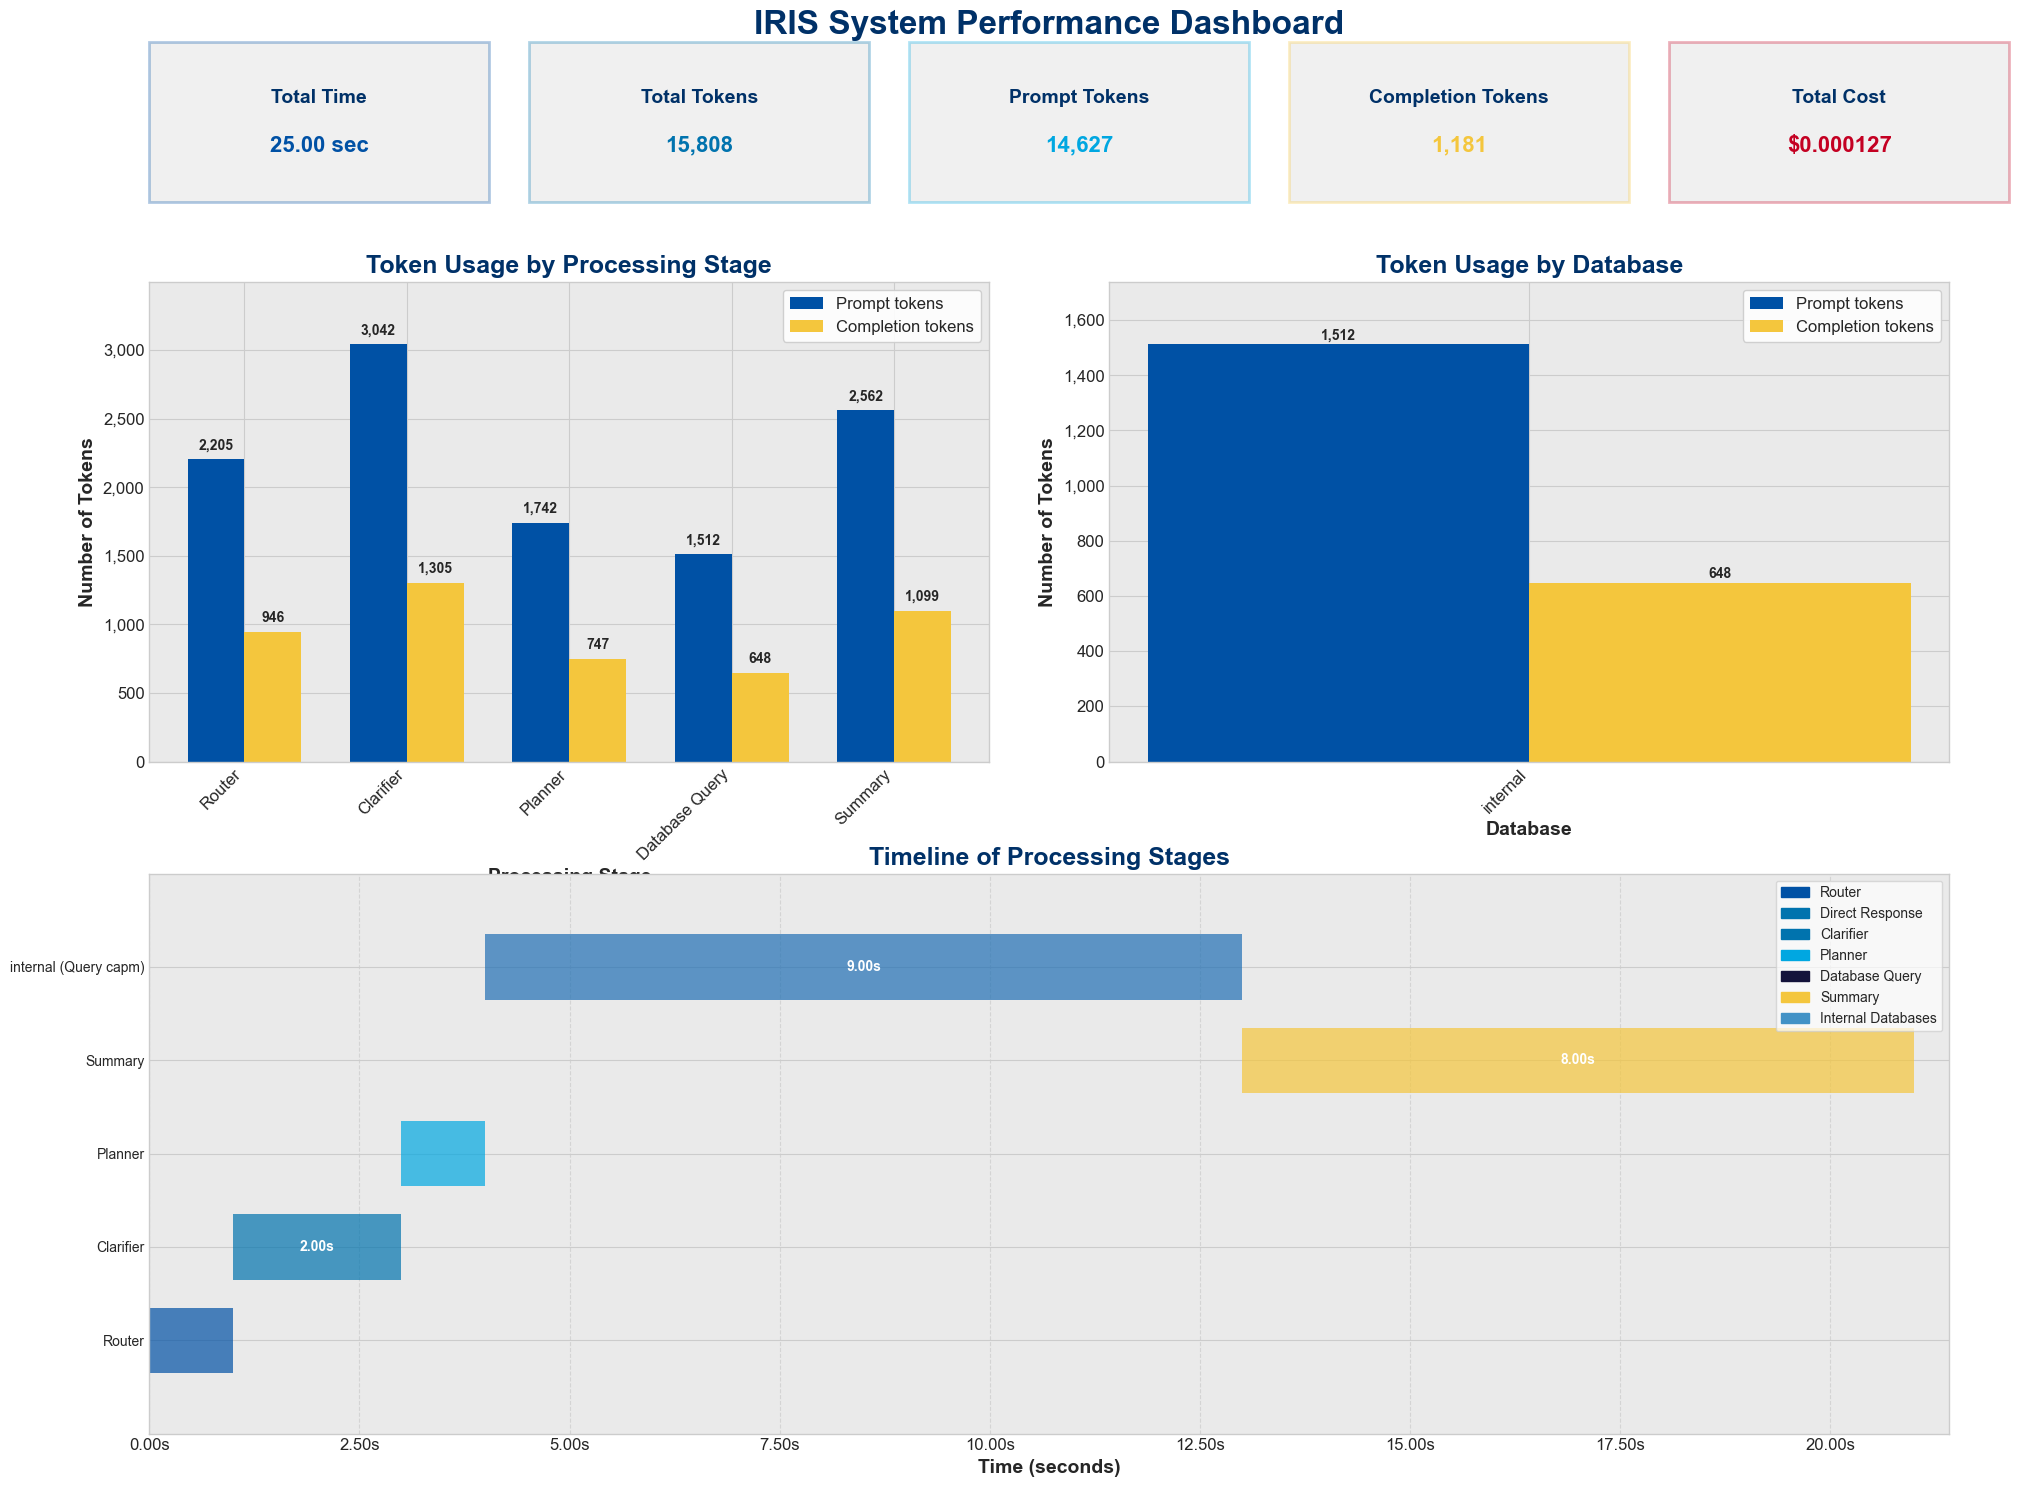

In [8]:
# Set up a widescreen dashboard visualization for process analytics and token usage
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors  # Add this import for rgb2hex
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import re
import json

# RBC color theme
rbc_colors = {
    'primary_blue': '#0051A5',  # RBC Royal Blue
    'secondary_blue': '#0073AE', # RBC Secondary Blue
    'accent_blue': '#00A7E1',   # RBC Light Blue
    'dark_blue': '#003168',     # RBC Dark Blue
    'gold': '#F4C63D',          # RBC Gold
    'navy': '#14133B',          # RBC Navy
    'red': '#C40022',           # RBC Red
    'light_gray': '#EAEAEA',    # Light Gray for backgrounds
    'medium_gray': '#D0D0D0'    # Medium Gray for tile backgrounds
}

# Set the matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

# Parse the process monitor data or use legacy data
if process_monitor_output:
    # Extract stages information from the monitoring output
    # Try to parse the formatted output into a structured data object
    stages_data = []
    
    # Parse the monitoring output
    # Extract overall stats
    total_duration_match = re.search(r'Total Duration: (\d+\.\d+) seconds', process_monitor_output)
    total_duration = float(total_duration_match.group(1)) if total_duration_match else 25.0  # Set default value if not found
    
    prompt_tokens_match = re.search(r'Prompt Tokens: (\d+)', process_monitor_output)
    prompt_tokens = int(prompt_tokens_match.group(1)) if prompt_tokens_match else 0
    
    completion_tokens_match = re.search(r'Completion Tokens: (\d+)', process_monitor_output)
    completion_tokens = int(completion_tokens_match.group(1)) if completion_tokens_match else 0
    
    total_tokens_match = re.search(r'Total Tokens: (\d+)', process_monitor_output)
    total_tokens = int(total_tokens_match.group(1)) if total_tokens_match else 0
    
    cost_match = re.search(r'Cost: \$(\d+\.\d+)', process_monitor_output)
    cost = float(cost_match.group(1)) if cost_match else 0
    
    # Define a dictionary to hold our total stats
    monitor_stats = {
        "total_duration": total_duration,
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens,
        "cost": cost,
    }
    
    # Extract individual stages
    # Find all stage sections
    stage_pattern = r'([✅|❌|⏳]) \*\*([^*]+)\*\*\n(.*?)(?=(?:[✅|❌|⏳]) \*\*|$)'
    stage_matches = re.finditer(stage_pattern, process_monitor_output, re.DOTALL)
    
    # Process each stage
    for match in stage_matches:
        status_icon = match.group(1)
        stage_name = match.group(2).strip()
        stage_details = match.group(3).strip()
        
        # Determine status
        status = "completed" if status_icon == "✅" else "error" if status_icon == "❌" else "in_progress"
        
        # Extract start time
        start_time_match = re.search(r'Start: (\d{2}:\d{2}:\d{2})', stage_details)
        start_time = start_time_match.group(1) if start_time_match else None
        
        # Extract end time
        end_time_match = re.search(r'End: (\d{2}:\d{2}:\d{2})', stage_details)
        end_time = end_time_match.group(1) if end_time_match else None
        
        # Extract duration
        duration_match = re.search(r'Duration: (\d+\.\d+) seconds', stage_details)
        duration = float(duration_match.group(1)) if duration_match else None
        
        # Extract tokens if present
        tokens_match = re.search(r'Tokens: (\d+) \(Cost: \$(\d+\.\d+)\)', stage_details)
        tokens = int(tokens_match.group(1)) if tokens_match else 0
        token_cost = float(tokens_match.group(2)) if tokens_match else 0
        
        # Approximate prompt vs completion tokens based on common ratios if we only have total
        # This is a very rough approximation!
        if tokens > 0:
            prompt_tokens = int(tokens * 0.7)  # Assume 70% prompt tokens
            completion_tokens = tokens - prompt_tokens
        else:
            prompt_tokens = 0
            completion_tokens = 0
        
        # Extract any additional details
        details = {}
        detail_matches = re.finditer(r'- ([^:]+): (.+)', stage_details)
        for detail_match in detail_matches:
            key = detail_match.group(1).strip()
            value = detail_match.group(2).strip()
            details[key] = value
        
        # Create a data record for this stage
        if start_time:  # Only include stages that have started
            stages_data.append({
                'stage': stage_name,
                'status': status,
                'start_time': start_time,
                'end_time': end_time if end_time else start_time,  # Use start time if end time not available
                'duration': duration if duration else 0,
                'prompt_tokens': prompt_tokens,
                'completion_tokens': completion_tokens,
                'total_tokens': tokens,
                'cost': token_cost,
                'details': details
            })
    
    # Create a DataFrame from our parsed data
    df_stages = pd.DataFrame(stages_data)
    
    # Identify database query stages
    db_query_stages = df_stages[df_stages['stage'].str.startswith('db_query_')].copy()
    
    # Create a dataframe for database summary
    if not db_query_stages.empty:
        # Extract database name and query index from stage name (format: db_query_db_name_index)
        db_query_stages['database'] = db_query_stages['stage'].apply(
            lambda x: x.split('_')[2] if len(x.split('_')) > 2 else x
        )
        
        # Add query index to preserve individual queries
        db_query_stages['query_index'] = db_query_stages['stage'].apply(
            lambda x: x.split('_')[3] if len(x.split('_')) > 3 else '1'
        )
        
        # Keep individual queries separate - don't group
        db_summary = db_query_stages.copy()
        
        # Make display name more readable - use the actual database names
        db_summary['display_name'] = db_summary['database']
    else:
        # Create an empty dataframe if no database queries
        db_summary = pd.DataFrame(columns=['database', 'query_index', 'display_name', 'prompt_tokens', 
                                         'completion_tokens', 'total_tokens', 'cost', 'duration'])
    
    # Create normal stages summary (aggregating all db_query stages)
    normal_stages_summary = []
    
    # Group stages into logical categories - removing the first three stages
    stage_categories = {
        'router': ['router'],
        'clarifier': ['clarifier'],
        'planner': ['planner'],
        'database_query': [s for s in df_stages['stage'] if s.startswith('db_query_')],
        'summary': ['summary'],
        'direct_response': ['direct_response']
    }
    
    # Categorize each stage (excluding the setup stages)
    for stage_name in df_stages['stage'].unique():
        # Skip SSL, OAuth, and conversation processing stages
        if stage_name in ['ssl_setup', 'oauth_setup', 'conversation_processing']:
            continue
            
        categorized = False
        for category, stage_list in stage_categories.items():
            if stage_name in stage_list:
                categorized = True
                break
            elif category == 'database_query' and stage_name.startswith('db_query_'):
                categorized = True
                break
        
        # If not categorized, add to the appropriate category or create a new one
        if not categorized:
            # Try to match with an existing category
            if stage_name.endswith('_setup'):
                stage_categories.setdefault('setup', []).append(stage_name)
            else:
                # Create a new category for this stage
                stage_categories[stage_name] = [stage_name]
    
    # Create summary for each category
    for category, stage_list in stage_categories.items():
        if category == 'database_query':
            category_stages = df_stages[df_stages['stage'].str.startswith('db_query_')]
        else:
            category_stages = df_stages[df_stages['stage'].isin(stage_list)]
        
        if not category_stages.empty:
            normal_stages_summary.append({
                'stage': category,
                'prompt_tokens': category_stages['prompt_tokens'].sum(),
                'completion_tokens': category_stages['completion_tokens'].sum(),
                'total_tokens': category_stages['total_tokens'].sum(),
                'cost': category_stages['cost'].sum(),
                'duration': category_stages['duration'].sum()
            })
    
    # Create dataframe for normal stages
    df_normal_stages = pd.DataFrame(normal_stages_summary)
    
    # Define stage order and display names - updated to remove numbers and exclude first 3 stages
    stage_order = [
        'router',       # Router decision
        'direct_response', # Direct response path
        'clarifier',    # Clarify research needs
        'planner',      # Create query plan
        'database_query', # Execute database queries
        'summary',      # Generate final summary
    ]
    
    # Better display names for stages - without numbers
    stage_display_names = {
        'router': 'Router',
        'direct_response': 'Direct Response',
        'clarifier': 'Clarifier',
        'planner': 'Planner',
        'database_query': 'Database Query',
        'summary': 'Summary'
    }
    
    # Add any missing stages to the display names
    for stage in df_stages['stage'].unique():
        if stage not in stage_display_names and not stage.startswith('db_query_') and stage not in ['ssl_setup', 'oauth_setup', 'conversation_processing']:
            stage_display_names[stage] = stage.replace('_', ' ').title()
    
    # Add display names and order to dataframe
    df_normal_stages['display_name'] = df_normal_stages['stage'].map(
        lambda s: stage_display_names.get(s, s.replace('_', ' ').title())
    )
    
    # Set stage order using the predefined order, but handle stages not in the order list
    known_stages = {s: i for i, s in enumerate(stage_order)}
    df_normal_stages['stage_order'] = df_normal_stages['stage'].apply(
        lambda s: known_stages.get(s, 999)  # Use a high number for unknown stages
    )
    
    # Sort by stage order
    df_normal_stages = df_normal_stages.sort_values('stage_order')
    
    # Now create the timeline data - excluding the first three stages
    # Convert time strings to seconds since start of process
    first_time = None
    timeline_data = []
    
    for _, row in df_stages.iterrows():
        # Skip the setup and conversation processing stages
        if row['stage'] in ['ssl_setup', 'oauth_setup', 'conversation_processing']:
            continue
            
        # Convert times to datetime objects
        if row['start_time'] and row['end_time']:
            try:
                start_hour, start_minute, start_second = map(int, row['start_time'].split(':'))
                end_hour, end_minute, end_second = map(int, row['end_time'].split(':'))
                
                start_dt = datetime.now().replace(hour=start_hour, minute=start_minute, second=start_second, microsecond=0)
                end_dt = datetime.now().replace(hour=end_hour, minute=end_minute, second=end_second, microsecond=0)
                
                # Handle day rollover if end time is earlier than start time
                if end_dt < start_dt:
                    end_dt = end_dt.replace(day=end_dt.day + 1)
                
                # Track the first time for relative calculations
                if first_time is None:
                    first_time = start_dt
                
                # Calculate relative seconds from first event
                start_seconds = (start_dt - first_time).total_seconds()
                end_seconds = (end_dt - first_time).total_seconds()
                
                timeline_data.append({
                    'stage': row['stage'],
                    'start_seconds': start_seconds,
                    'end_seconds': end_seconds,
                    'duration': end_seconds - start_seconds
                })
            except (ValueError, TypeError) as e:
                print(f"Error processing timeline data for {row['stage']}: {e}")
    
    # Create dataframe for timeline
    df_timeline = pd.DataFrame(timeline_data)
    
    # Sort timeline by start time to ensure proper ordering
    df_timeline = df_timeline.sort_values('start_seconds')
    
    # For the timeline, keep database queries separate, don't categorize them
    def get_display_stage(stage_name):
        if stage_name.startswith('db_query_'):
            parts = stage_name.split('_')
            if len(parts) > 2:
                db_name = parts[2]
                query_idx = parts[3] if len(parts) > 3 else '1'
                return f"{db_name} (Query {query_idx})"  # Use actual database name
            else:
                return "DB: Unknown"
        else:
            return stage_display_names.get(stage_name, stage_name.replace('_', ' ').title())
    
    # Add display names to timeline data
    df_timeline['display_stage'] = df_timeline['stage'].apply(get_display_stage)
    
    # Define colors for different stages - expanded to include all stages
    stage_colors = {
        'router': rbc_colors['primary_blue'],
        'direct_response': rbc_colors['secondary_blue'],
        'clarifier': rbc_colors['secondary_blue'],
        'planner': rbc_colors['accent_blue'],
        'database_query': rbc_colors['navy'],
        'summary': rbc_colors['gold'],
    }
    
    # Add colors for database stages (use different colors for internal/external)
    if not db_query_stages.empty:
        # Create separate color schemes for internal and external databases
        internal_cmap = plt.cm.Blues(np.linspace(0.4, 0.8, 10))  # More blue space for potential internal DBs
        external_cmap = plt.cm.Oranges(np.linspace(0.4, 0.8, 10))  # Orange for external
        
        db_colors = {}
        for stage in df_timeline['stage']:
            if stage.startswith('db_query_'):
                parts = stage.split('_')
                if len(parts) > 2:
                    db_name = parts[2]
                    query_idx = parts[3] if len(parts) > 3 else '1'
                    is_external = 'external' in db_name
                    db_display = f"{db_name} (Query {query_idx})"  # Use actual database name
                    
                    # Choose color based on internal/external
                    if is_external:
                        idx = hash(db_name) % len(external_cmap)
                        color = mcolors.rgb2hex(external_cmap[idx])
                    else:
                        idx = hash(db_name) % len(internal_cmap)
                        color = mcolors.rgb2hex(internal_cmap[idx])
                    
                    db_colors[db_display] = color
        
        # Add these colors to the stage colors dict
        for db_display, color in db_colors.items():
            stage_colors[db_display] = color
    
    # Create the dashboard layout
    fig = plt.figure(figsize=(20, 16))
    
    # Create top stats tiles - fixed layout
    # 1. Create a row of 5 tiles at the top - one for each stat and cost
    stat_tiles = [
        {"title": "Total Time", "value": f"{monitor_stats['total_duration']:.2f} sec", "color": rbc_colors['primary_blue']},
        {"title": "Total Tokens", "value": f"{monitor_stats['total_tokens']:,}", "color": rbc_colors['secondary_blue']},
        {"title": "Prompt Tokens", "value": f"{monitor_stats['prompt_tokens']:,}", "color": rbc_colors['accent_blue']},
        {"title": "Completion Tokens", "value": f"{monitor_stats['completion_tokens']:,}", "color": rbc_colors['gold']},
        {"title": "Total Cost", "value": f"${monitor_stats['cost']:.6f}", "color": rbc_colors['red']}
    ]
    
    # Create stats row - manually positioned rectangles 
    for i, stat in enumerate(stat_tiles):
        # Calculate position for each tile
        left = 0.05 + (i * 0.19)  # 5 tiles across the full width with small gaps
        bottom = 0.85
        width = 0.17
        height = 0.10
        
        # Create a rectangle for the tile
        rect = patches.Rectangle((left, bottom), width, height, 
                                linewidth=2, edgecolor=stat["color"],
                                facecolor=rbc_colors['medium_gray'], alpha=0.3)
        fig.add_artist(rect)
        
        # Add text directly to the figure
        fig.text(left + width/2, bottom + height*0.65, stat["title"], 
                ha='center', va='center', fontsize=14, fontweight='bold', 
                color=rbc_colors['dark_blue'])
        
        fig.text(left + width/2, bottom + height*0.35, stat["value"], 
                ha='center', va='center', fontsize=16, fontweight='bold',
                color=stat["color"])
    
    # Token Usage Charts Row - create two axes side by side
    ax_tokens = fig.add_axes([0.05, 0.5, 0.42, 0.3])  # [left, bottom, width, height]
    ax_db = fig.add_axes([0.53, 0.5, 0.42, 0.3])
    
    # Timeline row - larger chart at bottom
    ax_timeline = fig.add_axes([0.05, 0.08, 0.9, 0.35])
    
    # Add title at the top
    fig.text(0.5, 0.96, 'IRIS System Performance Dashboard', 
            ha='center', va='center', fontsize=24, fontweight='bold',
            color=rbc_colors['dark_blue'])
    
    # 1. Create the Token Usage by Stage chart
    if not df_normal_stages.empty:
        bar_width = 0.35
        x = np.arange(len(df_normal_stages))
        
        # Plot bar chart with larger bars
        prompt_bars = ax_tokens.bar(x - bar_width/2, df_normal_stages['prompt_tokens'], bar_width, 
                            label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_tokens.bar(x + bar_width/2, df_normal_stages['completion_tokens'], bar_width, 
                                label='Completion tokens', color=rbc_colors['gold'])
        
        # Add value labels on top of bars
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:  # Only add labels for non-zero bars
                    ax_tokens.text(bar.get_x() + bar.get_width()/2., height + 50,
                            f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax_tokens.set_xlabel('Processing Stage', fontsize=14, fontweight='bold')
        ax_tokens.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_tokens.set_title('Token Usage by Processing Stage', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_tokens.set_xticks(x)
        ax_tokens.set_xticklabels(df_normal_stages['display_name'], rotation=45, ha='right', fontsize=12)
        ax_tokens.tick_params(axis='y', labelsize=12)
        
        # Format y-axis with comma for thousands
        ax_tokens.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Add legend with better position
        ax_tokens.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        
        # Set background color
        ax_tokens.set_facecolor(rbc_colors['light_gray'])
        
        # Add extra space at top for labels
        if len(df_normal_stages) > 0:
            y_top = max([
                max(df_normal_stages['prompt_tokens']) if len(df_normal_stages) > 0 else 0, 
                max(df_normal_stages['completion_tokens']) if len(df_normal_stages) > 0 else 0
            ]) * 1.15
            ax_tokens.set_ylim(0, y_top if y_top > 0 else 100)
    else:
        ax_tokens.text(0.5, 0.5, "No stage data available", 
                    ha='center', va='center', fontsize=14, 
                    fontweight='bold', color=rbc_colors['dark_blue'])
    
    # 2. Create the Database Usage chart - use individual queries now
    if not db_summary.empty:
        # Create a grouped bar chart
        bar_width = 0.35
        x = np.arange(len(db_summary))
        
        # Plot bar chart with larger bars
        prompt_bars = ax_db.bar(x - bar_width/2, db_summary['prompt_tokens'], bar_width, 
                            label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_db.bar(x + bar_width/2, db_summary['completion_tokens'], bar_width, 
                                label='Completion tokens', color=rbc_colors['gold'])
        
        # Add value labels on top of bars
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:  # Only add labels for non-zero bars
                    ax_db.text(bar.get_x() + bar.get_width()/2., height + 5,
                            f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax_db.set_xlabel('Database', fontsize=14, fontweight='bold')
        ax_db.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_db.set_title('Token Usage by Database', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_db.set_xticks(x)
        ax_db.set_xticklabels(db_summary['display_name'], rotation=45, ha='right', fontsize=12)
        ax_db.tick_params(axis='y', labelsize=12)
        
        # Format y-axis with comma for thousands
        ax_db.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Add legend in a non-overlapping position
        ax_db.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        
        # Set background color
        ax_db.set_facecolor(rbc_colors['light_gray'])
        
        # Add extra space at top for labels
        if len(db_summary) > 0:
            y_top = max([
                max(db_summary['prompt_tokens']) if len(db_summary) > 0 else 0, 
                max(db_summary['completion_tokens']) if len(db_summary) > 0 else 0
            ]) * 1.15
            ax_db.set_ylim(0, y_top if y_top > 0 else 100)
    else:
        ax_db.text(0.5, 0.5, "No database query data available", 
                ha='center', va='center', fontsize=14, 
                fontweight='bold', color=rbc_colors['dark_blue'])
    
    # 3. Create the Timeline Visualization with individual database rows
    if not df_timeline.empty:
        # Create dictionary to track position of each stage
        stages_positioned = set()
        stage_positions = {}
        current_position = 0
        spacing = 1.0
        
        # First position the main stages in the defined order
        for stage in stage_order:
            if stage in df_timeline['stage'].values:
                stage_positions[stage] = current_position
                stages_positioned.add(stage)
                current_position += spacing
        
        # Then add database stages as individual rows - keep separate by stage name
        # Sort database stages to ensure consistent order
        db_stages = sorted([stage for stage in df_timeline['stage'] if stage.startswith('db_query_')])
        for db_stage in db_stages:
            if db_stage not in stages_positioned:
                stage_positions[db_stage] = current_position
                stages_positioned.add(db_stage)
                current_position += spacing
        
        # Finally add any remaining stages
        remaining_stages = sorted([stage for stage in df_timeline['stage'].unique() 
                                  if stage not in stages_positioned])
        for stage in remaining_stages:
            stage_positions[stage] = current_position
            stages_positioned.add(stage)
            current_position += spacing
        
        # Increase spacing between bars
        height = 0.7
        
        # Plot horizontal bars for each timeline entry
        for i, row in df_timeline.iterrows():
            stage = row['stage']
            duration = row['duration']
            start_pos = row['start_seconds']
            
            # Get the display stage for color mapping
            display_stage = row['display_stage']
            
            # Determine color based on stage type
            if stage.startswith('db_query_'):
                color = stage_colors.get(display_stage, 'gray')
            else:
                color = stage_colors.get(stage, 'gray')
            
            # Use the stage's position
            position = stage_positions[stage]
            
            # Create the bar with proper position and width
            ax_timeline.barh(position, duration, left=start_pos, height=height, color=color, alpha=0.7)
            
            # Add text label for bars with sufficient width
            if duration > 1.0:  # Only add label if bar is wide enough
                text_pos = start_pos + duration/2
                label = f"{duration:.2f}s"
                ax_timeline.text(text_pos, position, label, ha='center', va='center',
                        color='white', fontweight='bold', fontsize=10)
        
        # Prepare y-tick positions and labels
        positions = []
        labels = []
        
        # Add y-ticks in the order they appear in the plot
        for stage, position in sorted(stage_positions.items(), key=lambda x: x[1]):
            positions.append(position)
            # Use the display name for each stage in the timeline
            if stage.startswith('db_query_'):
                row = df_timeline[df_timeline['stage'] == stage].iloc[0]
                labels.append(row['display_stage'])
            else:
                labels.append(stage_display_names.get(stage, stage.replace('_', ' ').title()))
        
        ax_timeline.set_yticks(positions)
        ax_timeline.set_yticklabels(labels, fontsize=10)
        
        ax_timeline.set_xlabel('Time (seconds)', fontsize=14, fontweight='bold')
        ax_timeline.set_title('Timeline of Processing Stages', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_timeline.tick_params(axis='x', labelsize=12)
        
        # Add gridlines and format x-axis
        ax_timeline.grid(axis='x', linestyle='--', alpha=0.7)
        ax_timeline.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}s'))
        
        # Set background color
        ax_timeline.set_facecolor(rbc_colors['light_gray'])
        
        # Set appropriate x and y limits
        total_time = df_timeline['end_seconds'].max() if len(df_timeline) > 0 else 0
        ax_timeline.set_xlim(0, total_time * 1.02)  # Add a small margin
        
        # Add extra room at the top and bottom
        ax_timeline.set_ylim(-1, max(positions) + 1 if positions else 1)
        
        # Create a custom legend for stage types (not individual database stages)
        legend_items = []
        
        # Add main stages to legend
        for stage in stage_order:
            if stage in stage_colors:
                legend_items.append((stage_display_names.get(stage, stage.replace('_', ' ').title()), 
                                     stage_colors[stage]))
        
        # Add legend entries for internal/external databases
        if any(stage.startswith('db_query_') for stage in df_timeline['stage']):
            internal_db = any('internal' in stage for stage in db_stages)
            external_db = any('external' in stage for stage in db_stages)
            
            if internal_db:
                legend_items.append(('Internal Databases', mcolors.rgb2hex(internal_cmap[5])))
            if external_db:
                legend_items.append(('External Databases', mcolors.rgb2hex(external_cmap[5])))
        
        # Create patches for the legend
        handles = [patches.Patch(color=color, label=name) for name, color in legend_items]
        ax_timeline.legend(handles=handles, loc='upper right', fontsize=10, frameon=True, framealpha=0.7)
    else:
        ax_timeline.text(0.5, 0.5, "No timeline data available", 
                    ha='center', va='center', fontsize=14, 
                    fontweight='bold', color=rbc_colors['dark_blue'])
    
    # Adjust figure layout
    plt.show()
    
# Fall back to legacy debug data if no process monitor output is available
elif debug_data:
    # Insert the original dashboard code here for compatibility
    # Sort the decisions by timestamp to ensure correct ordering
    decisions_sorted = sorted(debug_data['decisions'], key=lambda x: datetime.fromisoformat(x['timestamp']))
    
    # Define stage order and display names - without numbers
    stage_order = [
        'router',       # Router decision
        'clarifier',    # Clarify research needs
        'planner',      # Create query plan
        'database_query', # Execute database queries
        'judge',        # Evaluate research progress
        'summary'       # Generate final summary
    ]
    
    # Better display names for stages - without numbers
    stage_display_names = {
        'router': 'Router',
        'clarifier': 'Clarifier',
        'planner': 'Planner',
        'database_query': 'Database Query',
        'judge': 'Judge',
        'summary': 'Summary'
    }
    
    # Get the overall start and end times
    overall_start = datetime.fromisoformat(debug_data['start_timestamp'])
    overall_end = datetime.fromisoformat(debug_data['end_timestamp'])
    total_duration = (overall_end - overall_start).total_seconds()
    
    # Create dataframe from stage data
    stages_data = []
    for decision in decisions_sorted:
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        if 'token_usage' in decision:
            token_usage = decision['token_usage']
            stages_data.append({
                'stage': stage,
                'display_name': stage_display_names.get(stage, stage),
                'timestamp': timestamp,
                'prompt_tokens': token_usage.get('prompt_tokens', 0),
                'completion_tokens': token_usage.get('completion_tokens', 0),
                'total_tokens': token_usage.get('total_tokens', 0),
                'cost': token_usage.get('cost', 0.0)
            })
    
    # Create dataframe
    df_stages = pd.DataFrame(stages_data)
    
    # Calculate relative time from start
    df_stages['time_seconds'] = (df_stages['timestamp'] - overall_start).dt.total_seconds()
    
    # Group by stage and sum tokens
    stage_totals = df_stages.groupby(['stage', 'display_name']).agg({
        'prompt_tokens': 'sum',
        'completion_tokens': 'sum',
        'total_tokens': 'sum',
        'cost': 'sum'
    }).reset_index()
    
    # Sort by stage order
    stage_totals['stage_order'] = stage_totals['stage'].map({s: i for i, s in enumerate(stage_order)})
    stage_totals = stage_totals.sort_values('stage_order')
    
    # Create database data if available - keep original database name 
    db_data = []
    if debug_data['tokens'].get('databases'):
        for db_name, usage in debug_data['tokens']['databases'].items():
            # Use actual database name
            db_data.append({
                'database': db_name,
                'display_name': db_name,
                'prompt_tokens': usage.get('prompt_tokens', 0),
                'completion_tokens': usage.get('completion_tokens', 0),
                'total_tokens': usage.get('total_tokens', 0),
                'cost': usage.get('cost', 0.0)
            })
        
        # Create dataframe
        df_db = pd.DataFrame(db_data)
    
    # Define colors for different stages
    stage_colors = {
        'router': rbc_colors['primary_blue'],
        'clarifier': rbc_colors['secondary_blue'],
        'planner': rbc_colors['accent_blue'],
        'database_query': rbc_colors['navy'],
        'judge': rbc_colors['gold'],
        'summary': rbc_colors['red']
    }
    
    # Create the dashboard layout
    fig = plt.figure(figsize=(20, 16))
    
    # Create top stats tiles - fixed layout
    # 1. Create a row of 5 tiles at the top - one for each stat and cost
    stat_tiles = [
        {"title": "Total Time", "value": f"{total_duration:.2f} sec", "color": rbc_colors['primary_blue']},
        {"title": "Total Tokens", "value": f"{debug_data['tokens']['total']:,}", "color": rbc_colors['secondary_blue']},
        {"title": "Prompt Tokens", "value": f"{debug_data['tokens']['prompt']:,}", "color": rbc_colors['accent_blue']},
        {"title": "Completion Tokens", "value": f"{debug_data['tokens']['completion']:,}", "color": rbc_colors['gold']},
        {"title": "Total Cost", "value": f"${debug_data['cost']:.6f}", "color": rbc_colors['red']}
    ]
    
    # Create stats row - manually positioned rectangles 
    for i, stat in enumerate(stat_tiles):
        # Calculate position for each tile
        left = 0.05 + (i * 0.19)  # 5 tiles across the full width with small gaps
        bottom = 0.85
        width = 0.17
        height = 0.10
        
        # Create a rectangle for the tile
        rect = patches.Rectangle((left, bottom), width, height, 
                                linewidth=2, edgecolor=stat["color"],
                                facecolor=rbc_colors['medium_gray'], alpha=0.3)
        fig.add_artist(rect)
        
        # Add text directly to the figure
        fig.text(left + width/2, bottom + height*0.65, stat["title"], 
                ha='center', va='center', fontsize=14, fontweight='bold', 
                color=rbc_colors['dark_blue'])
        
        fig.text(left + width/2, bottom + height*0.35, stat["value"], 
                ha='center', va='center', fontsize=16, fontweight='bold',
                color=stat["color"])
    
    # Token Usage Charts Row - create two axes side by side
    ax_tokens = fig.add_axes([0.05, 0.5, 0.42, 0.3])  # [left, bottom, width, height]
    ax_db = fig.add_axes([0.53, 0.5, 0.42, 0.3])
    
    # Timeline row - larger chart at bottom
    ax_timeline = fig.add_axes([0.05, 0.08, 0.9, 0.35])
    
    # Add title at the top
    fig.text(0.5, 0.96, 'IRIS System Performance Dashboard', 
            ha='center', va='center', fontsize=24, fontweight='bold',
            color=rbc_colors['dark_blue'])
    
    # 1. Create the Token Usage by Stage chart
    bar_width = 0.35
    x = np.arange(len(stage_totals))
    
    # Plot bar chart with larger bars
    prompt_bars = ax_tokens.bar(x - bar_width/2, stage_totals['prompt_tokens'], bar_width, 
                         label='Prompt tokens', color=rbc_colors['primary_blue'])
    completion_bars = ax_tokens.bar(x + bar_width/2, stage_totals['completion_tokens'], bar_width, 
                             label='Completion tokens', color=rbc_colors['gold'])
    
    # Add value labels on top of bars
    for bars in [prompt_bars, completion_bars]:
        for bar in bars:
            height = bar.get_height()
            ax_tokens.text(bar.get_x() + bar.get_width()/2., height + 50,
                    f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax_tokens.set_xlabel('Processing Stage', fontsize=14, fontweight='bold')
    ax_tokens.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
    ax_tokens.set_title('Token Usage by Processing Stage', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_tokens.set_xticks(x)
    ax_tokens.set_xticklabels(stage_totals['display_name'], rotation=45, ha='right', fontsize=12)
    ax_tokens.tick_params(axis='y', labelsize=12)
    
    # Format y-axis with comma for thousands
    ax_tokens.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    # Add legend with better position
    ax_tokens.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
    
    # Set background color
    ax_tokens.set_facecolor(rbc_colors['light_gray'])
    
    # Add extra space at top for labels
    y_top = max([max(stage_totals['prompt_tokens']), max(stage_totals['completion_tokens'])]) * 1.15
    ax_tokens.set_ylim(0, y_top)
    
    # 2. Create the Database Usage chart
    if 'df_db' in locals():
        # Create a grouped bar chart
        x = np.arange(len(df_db))
        
        # Plot bar chart with larger bars
        prompt_bars = ax_db.bar(x - bar_width/2, df_db['prompt_tokens'], bar_width, 
                             label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_db.bar(x + bar_width/2, df_db['completion_tokens'], bar_width, 
                                 label='Completion tokens', color=rbc_colors['gold'])
        
        # Add value labels on top of bars
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                ax_db.text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax_db.set_xlabel('Database', fontsize=14, fontweight='bold')
        ax_db.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_db.set_title('Token Usage by Database', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_db.set_xticks(x)
        ax_db.set_xticklabels(df_db['display_name'], rotation=45, ha='right', fontsize=12)
        ax_db.tick_params(axis='y', labelsize=12)
        
        # Format y-axis with comma for thousands
        ax_db.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Add legend in a non-overlapping position
        ax_db.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        
        # Set background color
        ax_db.set_facecolor(rbc_colors['light_gray'])
        
        # Add extra space at top for labels
        y_top = max([max(df_db['prompt_tokens']), max(df_db['completion_tokens'])]) * 1.15
        ax_db.set_ylim(0, y_top)
    
    # 3. Create the Detailed Timeline Visualization
    # We need to keep ALL stage transitions in chronological order
    detailed_timeline = []
    
    for i, decision in enumerate(decisions_sorted):
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        
        # End time is either the next decision's timestamp or the end timestamp
        if i + 1 < len(decisions_sorted):
            end_time = datetime.fromisoformat(decisions_sorted[i+1]['timestamp'])
        else:
            end_time = overall_end
        
        # Calculate relative times
        start_seconds = (timestamp - overall_start).total_seconds()
        end_seconds = (end_time - overall_start).total_seconds()
        duration = end_seconds - start_seconds
        
        # Add to detailed timeline
        detailed_timeline.append({
            'stage': stage,
            'display_name': stage_display_names.get(stage, stage),
            'start_seconds': start_seconds,
            'end_seconds': end_seconds,
            'duration': duration
        })
    
    # Create dataframe from detailed timeline
    df_detailed = pd.DataFrame(detailed_timeline)
    
    # Sort by start time to ensure chronological order
    df_detailed = df_detailed.sort_values('start_seconds')
    
    # Increase spacing between bars - MUCH larger height for visibility
    height = 0.8
    spacing = 1.5
    
    # Create a map of stage to positions (for consistent vertical position)
    unique_stages = list(stage_display_names.keys())
    stage_positions = {stage: i * spacing for i, stage in enumerate(reversed(unique_stages))}
    
    # Plot horizontal bars for each transition
    for i, row in df_detailed.iterrows():
        stage = row['stage']
        duration = row['duration']
        start_pos = row['start_seconds']
        duration_width = duration
        color = stage_colors.get(stage, 'gray')
        
        # Use the stage's consistent position
        position = stage_positions[stage]
        
        # Create the bar with proper position and width
        ax_timeline.barh(position, duration_width, left=start_pos, height=height, color=color)
        
        # Add text label for bars with sufficient width
        if duration_width > 1.5:
            text_pos = start_pos + duration_width/2
            label = f"{row['duration']:.2f}s"
            ax_timeline.text(text_pos, position, label, ha='center', va='center',
                    color='white', fontweight='bold', fontsize=12)
    
    # Adjust y-ticks and labels
    positions = list(stage_positions.values())
    # Use stage names without numbers
    stage_names = [stage_display_names[s] for s in reversed(unique_stages)]
    
    ax_timeline.set_yticks(positions)
    ax_timeline.set_yticklabels(stage_names, fontsize=12)
    
    ax_timeline.set_xlabel('Time (seconds)', fontsize=14, fontweight='bold')
    ax_timeline.set_title('Timeline of Processing Stages', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_timeline.tick_params(axis='x', labelsize=12)
    
    # Add gridlines and format x-axis with decimal places
    ax_timeline.grid(axis='x', linestyle='--', alpha=0.7)
    ax_timeline.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}s'))
    
    # Set background color
    ax_timeline.set_facecolor(rbc_colors['light_gray'])
    
    # Set appropriate x and y limits
    ax_timeline.set_xlim(0, total_duration * 1.02)  # Add a small margin
    ax_timeline.set_ylim(-1, max(positions) + 1)
    
    # Add legend for timeline stages 
    handles = [patches.Patch(color=color, label=stage_display_names.get(stage, stage)) 
              for stage, color in stage_colors.items()]
    ax_timeline.legend(handles=handles, loc='upper right', fontsize=12, frameon=True, framealpha=0.7)
    
    # Adjust figure layout
    plt.show()
else:
    print("No debug data available. Make sure to run with debug_mode=True.")